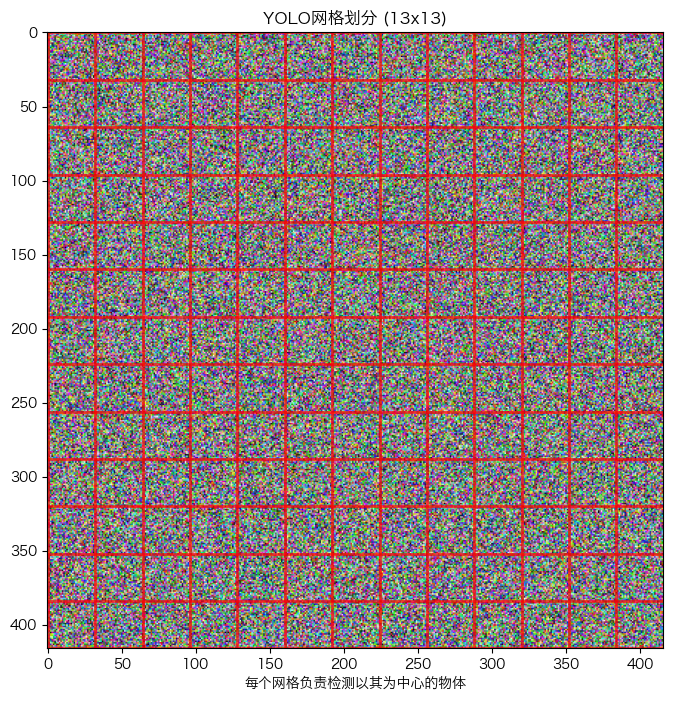

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# ÂÖ®Â±Ä‰∏≠ÊñáÂ≠ó‰ΩìËÆæÁΩÆÔºàmacOS/Â∏∏ËßÅÂπ≥Âè∞ÈÄöÁî®Ôºâ
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

available_fonts = {f.name for f in font_manager.fontManager.ttflist}
preferred_fonts = [
    "PingFang SC", "Hiragino Sans GB", "Heiti SC", "SimHei",
    "Microsoft YaHei", "Noto Sans CJK SC", "Arial Unicode MS"
]
for name in preferred_fonts:
    if name in available_fonts:
        rcParams["font.sans-serif"] = [name]
        break

rcParams["axes.unicode_minus"] = False  # ‰øÆÂ§çË¥üÂè∑ÊòæÁ§∫‰∏∫ÊñπÂùóÁöÑÈóÆÈ¢ò

# Ê®°Êãü‰∏Ä‰∏™ÁÆÄÂçïÁöÑÂõæÂÉèÁΩëÊ†ºÂåñËøáÁ®ã
def visualize_grid(image_size=416, grid_size=13):
    """ÂèØËßÜÂåñYOLOÁöÑÁΩëÊ†ºÂàíÂàÜ"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # ÂàõÂª∫‰∏Ä‰∏™Á§∫‰æãÂõæÂÉè
    image = np.random.rand(image_size, image_size, 3)
    
    # ÁªòÂà∂ÁΩëÊ†ºÁ∫ø
    step = image_size // grid_size
    for i in range(0, image_size + 1, step):
        ax.axhline(y=i, color='red', linewidth=2, alpha=0.7)
        ax.axvline(x=i, color='red', linewidth=2, alpha=0.7)
    
    ax.imshow(image)
    ax.set_title(f'YOLOÁΩëÊ†ºÂàíÂàÜ ({grid_size}x{grid_size})')
    ax.set_xlabel('ÊØè‰∏™ÁΩëÊ†ºË¥üË¥£Ê£ÄÊµã‰ª•ÂÖ∂‰∏∫‰∏≠ÂøÉÁöÑÁâ©‰Ωì')
    plt.show()

# ÂèØËßÜÂåñÁΩëÊ†º
visualize_grid()

In [6]:
class YOLOPrediction:
    """ÁêÜËß£YOLOÁöÑÈ¢ÑÊµãËæìÂá∫Ê†ºÂºè"""
    
    def __init__(self, grid_size=7, num_classes=20, num_boxes=2):
        self.S = grid_size      # ÁΩëÊ†ºÂ§ßÂ∞è 7x7
        self.B = num_boxes      # ÊØè‰∏™ÁΩëÊ†ºÈ¢ÑÊµãÁöÑËæπÁïåÊ°ÜÊï∞Èáè
        self.C = num_classes    # Á±ªÂà´Êï∞Èáè
        
    def explain_output_tensor(self):
        """Ëß£ÈáäYOLOËæìÂá∫Âº†ÈáèÁöÑÂê´‰πâ"""
        print("YOLOËæìÂá∫Âº†ÈáèÂΩ¢Áä∂Ëß£ÈáäÔºö")
        print(f"ËæìÂá∫ÂΩ¢Áä∂: [{self.S}, {self.S}, {self.B * 5 + self.C}]")
        print(f"ÂÖ∑‰ΩìÊï∞ÂÄº: [7, 7, {self.B * 5 + self.C}]")
        print("\nÊØè‰∏™ÁΩëÊ†ºÁöÑÈ¢ÑÊµãÂåÖÂê´Ôºö")
        
        for b in range(self.B):
            print(f"ËæπÁïåÊ°Ü{b+1}: [x, y, w, h, confidence] = 5‰∏™ÂÄº")
        
        print(f"Á±ªÂà´Ê¶ÇÁéá: [{self.C}‰∏™Á±ªÂà´ÁöÑÊ¶ÇÁéá]")
        print(f"\nÊÄªËÆ°ÊØè‰∏™ÁΩëÊ†º: {self.B} √ó 5 + {self.C} = {self.B * 5 + self.C}‰∏™È¢ÑÊµãÂÄº")

# ÂàõÂª∫È¢ÑÊµãËß£ÈáäÂô®
predictor = YOLOPrediction()
predictor.explain_output_tensor()

YOLOËæìÂá∫Âº†ÈáèÂΩ¢Áä∂Ëß£ÈáäÔºö
ËæìÂá∫ÂΩ¢Áä∂: [7, 7, 30]
ÂÖ∑‰ΩìÊï∞ÂÄº: [7, 7, 30]

ÊØè‰∏™ÁΩëÊ†ºÁöÑÈ¢ÑÊµãÂåÖÂê´Ôºö
ËæπÁïåÊ°Ü1: [x, y, w, h, confidence] = 5‰∏™ÂÄº
ËæπÁïåÊ°Ü2: [x, y, w, h, confidence] = 5‰∏™ÂÄº
Á±ªÂà´Ê¶ÇÁéá: [20‰∏™Á±ªÂà´ÁöÑÊ¶ÇÁéá]

ÊÄªËÆ°ÊØè‰∏™ÁΩëÊ†º: 2 √ó 5 + 20 = 30‰∏™È¢ÑÊµãÂÄº


In [ ]:
class SimpleYOLO(nn.Module):
    """ÁÆÄÂåñÁâàYOLOÁΩëÁªúÔºå‰æø‰∫éÁêÜËß£Ê†∏ÂøÉÊ¶ÇÂøµ"""
    
    def __init__(self, grid_size=7, num_boxes=2, num_classes=20):
        super(SimpleYOLO, self).__init__()
        
        self.S = grid_size
        self.B = num_boxes  
        self.C = num_classes
        
        # ÁâπÂæÅÊèêÂèñÈÉ®ÂàÜÔºàÁ±ª‰ººResNetÁöÑÊÄùÊÉ≥Ôºâ
        self.features = nn.Sequential(
            # Á¨¨‰∏ÄÁªÑÂç∑ÁßØÂ±Ç
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Á¨¨‰∫åÁªÑÂç∑ÁßØÂ±Ç
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Á¨¨‰∏âÁªÑÂç∑ÁßØÂ±Ç
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Á¨¨ÂõõÁªÑÂç∑ÁßØÂ±Ç
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Ê£ÄÊµãÂ§¥ÈÉ®ÂàÜ
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((self.S, self.S)),  # Á°Æ‰øùËæìÂá∫ÊòØSxS
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, self.B * 5 + self.C, kernel_size=1),  # ÊúÄÁªàÈ¢ÑÊµãÂ±Ç
        )
        
    def forward(self, x):
        # ÁâπÂæÅÊèêÂèñ
        features = self.features(x)
        print(f"ÁâπÂæÅÊèêÂèñÂêéÁöÑÂΩ¢Áä∂: {features.shape}")
        
        # Ê£ÄÊµãÈ¢ÑÊµã
        output = self.classifier(features)
        print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        
        # ÈáçÂ°ë‰∏∫ [batch_size, S, S, B*5+C]
        batch_size = output.size(0)
        output = output.permute(0, 2, 3, 1)  # [B, S, S, B*5+C]
        
        return output

# ÂàõÂª∫Ê®°ÂûãÂπ∂ÊµãËØï
model = SimpleYOLO(grid_size=7, num_boxes=2, num_classes=20)
dummy_input = torch.randn(1, 3, 448, 448)  # YOLOÂÖ∏ÂûãËæìÂÖ•Â∞∫ÂØ∏

print("YOLOÁΩëÁªúÁªìÊûÑÊµãËØïÔºö")
output = model(dummy_input)
print(f"ÊúÄÁªàËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
print(f"Ëß£Èáä: [batch_size={output.shape[0]}, grid_height={output.shape[1]}, grid_width={output.shape[2]}, predictions={output.shape[3]}]")

In [ ]:
def parse_yolo_output(predictions, grid_size=7, num_boxes=2, num_classes=20):
    """Ëß£ÊûêYOLOÁöÑÂéüÂßãÈ¢ÑÊµãËæìÂá∫"""
    
    batch_size, S, S, _ = predictions.shape
    
    # ÂàÜÁ¶ª‰∏çÂêåÁ±ªÂûãÁöÑÈ¢ÑÊµã
    # ËæπÁïåÊ°ÜÈ¢ÑÊµãÔºöÂâçB*5‰∏™ÂÄº
    box_predictions = predictions[:, :, :, :num_boxes*5]
    box_predictions = box_predictions.view(batch_size, S, S, num_boxes, 5)
    
    # Á±ªÂà´È¢ÑÊµãÔºöÂêéC‰∏™ÂÄº
    class_predictions = predictions[:, :, :, num_boxes*5:]
    
    print("YOLOÈ¢ÑÊµãËß£ÊûêÔºö")
    print(f"ËæπÁïåÊ°ÜÈ¢ÑÊµãÂΩ¢Áä∂: {box_predictions.shape}")
    print(f"Á±ªÂà´È¢ÑÊµãÂΩ¢Áä∂: {class_predictions.shape}")
    
    # Ëß£ÈáäÊØè‰∏™ÈÉ®ÂàÜ
    print("\nËæπÁïåÊ°ÜÈ¢ÑÊµãÂåÖÂê´Ôºö")
    print("- x, y: ËæπÁïåÊ°Ü‰∏≠ÂøÉÁõ∏ÂØπ‰∫éÁΩëÊ†ºÁöÑÂÅèÁßª (0-1)")
    print("- w, h: ËæπÁïåÊ°ÜÂÆΩÈ´òÁõ∏ÂØπ‰∫éÊï¥ÂõæÁöÑÊØî‰æã (0-1)")
    print("- confidence: ËØ•Ê°ÜÂåÖÂê´Áâ©‰ΩìÁöÑÁΩÆ‰ø°Â∫¶ (0-1)")
    
    print("\nÁ±ªÂà´È¢ÑÊµãÂåÖÂê´Ôºö")
    print(f"- {num_classes}‰∏™Á±ªÂà´ÁöÑÊ¶ÇÁéáÂàÜÂ∏É")
    
    return box_predictions, class_predictions

# ‰ΩøÁî®ÂâçÈù¢ÁöÑÊ®°ÂûãËæìÂá∫
box_pred, class_pred = parse_yolo_output(output)

In [ ]:
class YOLOLoss(nn.Module):
    """YOLOÊçüÂ§±ÂáΩÊï∞ÁöÑËØ¶ÁªÜÂÆûÁé∞ÂíåËß£Èáä"""
    
    def __init__(self, S=7, B=2, C=20, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.S = S                    # ÁΩëÊ†ºÂ§ßÂ∞è
        self.B = B                    # ÊØèÁΩëÊ†ºËæπÁïåÊ°ÜÊï∞
        self.C = C                    # Á±ªÂà´Êï∞
        self.lambda_coord = lambda_coord    # ÂùêÊ†áÊçüÂ§±ÊùÉÈáç
        self.lambda_noobj = lambda_noobj    # Êó†Áâ©‰ΩìÊçüÂ§±ÊùÉÈáç
        
    def forward(self, predictions, targets):
        """
        predictions: [batch_size, S, S, B*5+C]
        targets: [batch_size, S, S, B*5+C] (ground truth)
        """
        
        batch_size = predictions.size(0)
        
        # ÂàÜÁ¶ªÈ¢ÑÊµãÂíåÁúüÂÄº
        pred_boxes = predictions[:, :, :, :self.B*5].view(batch_size, self.S, self.S, self.B, 5)
        pred_classes = predictions[:, :, :, self.B*5:]
        
        target_boxes = targets[:, :, :, :self.B*5].view(batch_size, self.S, self.S, self.B, 5)
        target_classes = targets[:, :, :, self.B*5:]
        
        # 1. ÂùêÊ†áÊçüÂ§± (Âè™ÂØπÊúâÁâ©‰ΩìÁöÑÊ†ºÂ≠êËÆ°ÁÆó)
        coord_mask = target_boxes[:, :, :, :, 4] > 0  # confidence > 0Ë°®Á§∫ÊúâÁâ©‰Ωì
        
        # ÊèêÂèñÂùêÊ†á (x, y, w, h)
        pred_xy = pred_boxes[:, :, :, :, :2]
        pred_wh = pred_boxes[:, :, :, :, 2:4]
        target_xy = target_boxes[:, :, :, :, :2]
        target_wh = target_boxes[:, :, :, :, 2:4]
        
        # ÂùêÊ†áÊçüÂ§±ËÆ°ÁÆó
        coord_loss_xy = F.mse_loss(pred_xy[coord_mask], target_xy[coord_mask], reduction='sum')
        coord_loss_wh = F.mse_loss(torch.sqrt(pred_wh[coord_mask]), torch.sqrt(target_wh[coord_mask]), reduction='sum')
        coord_loss = self.lambda_coord * (coord_loss_xy + coord_loss_wh)
        
        # 2. ÁΩÆ‰ø°Â∫¶ÊçüÂ§±
        pred_conf = pred_boxes[:, :, :, :, 4]
        target_conf = target_boxes[:, :, :, :, 4]
        
        # ÊúâÁâ©‰ΩìÁöÑÁΩÆ‰ø°Â∫¶ÊçüÂ§±
        obj_loss = F.mse_loss(pred_conf[coord_mask], target_conf[coord_mask], reduction='sum')
        
        # Êó†Áâ©‰ΩìÁöÑÁΩÆ‰ø°Â∫¶ÊçüÂ§±
        noobj_mask = target_boxes[:, :, :, :, 4] == 0
        noobj_loss = self.lambda_noobj * F.mse_loss(pred_conf[noobj_mask], target_conf[noobj_mask], reduction='sum')
        
        # 3. ÂàÜÁ±ªÊçüÂ§± (Âè™ÂØπÊúâÁâ©‰ΩìÁöÑÊ†ºÂ≠êËÆ°ÁÆó)
        obj_mask_class = (target_boxes[:, :, :, 0, 4] > 0).unsqueeze(-1).expand_as(target_classes)
        class_loss = F.mse_loss(pred_classes[obj_mask_class], target_classes[obj_mask_class], reduction='sum')
        
        # ÊÄªÊçüÂ§±
        total_loss = coord_loss + obj_loss + noobj_loss + class_loss
        
        # ËøîÂõûËØ¶ÁªÜÁöÑÊçüÂ§±‰ø°ÊÅØ
        return {
            'total_loss': total_loss,
            'coord_loss': coord_loss,
            'obj_loss': obj_loss, 
            'noobj_loss': noobj_loss,
            'class_loss': class_loss
        }

# ÊºîÁ§∫ÊçüÂ§±ÂáΩÊï∞ÁöÑ‰ΩøÁî®
def demo_loss_function():
    """ÊºîÁ§∫YOLOÊçüÂ§±ÂáΩÊï∞ÁöÑËÆ°ÁÆóËøáÁ®ã"""
    
    criterion = YOLOLoss(S=7, B=2, C=20)
    
    # ÂàõÂª∫Ê®°ÊãüÁöÑÈ¢ÑÊµãÂíåÁúüÂÄº
    batch_size = 2
    predictions = torch.randn(batch_size, 7, 7, 30)  # ÈöèÊú∫È¢ÑÊµã
    targets = torch.zeros(batch_size, 7, 7, 30)      # Á©∫ÁôΩÁúüÂÄº
    
    # Âú®targets‰∏≠ËÆæÁΩÆ‰∏Ä‰∏™ÁúüÂÆûÁâ©‰Ωì
    targets[0, 3, 3, 4] = 0.9    # Á¨¨‰∏Ä‰∏™ËæπÁïåÊ°ÜÁöÑconfidence
    targets[0, 3, 3, 0:2] = torch.tensor([0.5, 0.5])  # ‰∏≠ÂøÉÁÇπ
    targets[0, 3, 3, 2:4] = torch.tensor([0.3, 0.4])  # ÂÆΩÈ´ò
    targets[0, 3, 3, 10] = 1.0   # Á¨¨‰∏Ä‰∏™Á±ªÂà´‰∏∫Ê≠£Ê†∑Êú¨
    
    # ËÆ°ÁÆóÊçüÂ§±
    loss_dict = criterion(predictions, targets)
    
    print("YOLOÊçüÂ§±ÂáΩÊï∞ËØ¶Ëß£Ôºö")
    print("-" * 50)
    for key, value in loss_dict.items():
        print(f"{key}: {value.item():.4f}")
    
    print("\nÊçüÂ§±ÂáΩÊï∞ÁªÑÊàêËß£ÈáäÔºö")
    print("1. coord_loss: ËæπÁïåÊ°ÜÂùêÊ†áÈ¢ÑÊµãÊçüÂ§±ÔºàÂä†ÊùÉÈáçŒª_coord=5Ôºâ")
    print("2. obj_loss: ÊúâÁâ©‰ΩìÊ†ºÂ≠êÁöÑÁΩÆ‰ø°Â∫¶ÊçüÂ§±")
    print("3. noobj_loss: Êó†Áâ©‰ΩìÊ†ºÂ≠êÁöÑÁΩÆ‰ø°Â∫¶ÊçüÂ§±ÔºàÂä†ÊùÉÈáçŒª_noobj=0.5Ôºâ")
    print("4. class_loss: Á±ªÂà´ÂàÜÁ±ªÊçüÂ§±")
    print("5. total_loss: ÊâÄÊúâÊçüÂ§±ÁöÑÊÄªÂíå")

demo_loss_function()

In [ ]:
def convert_predictions_to_boxes(predictions, grid_size=7, img_size=448):
    """Â∞ÜYOLOÁΩëÁªúÈ¢ÑÊµãËΩ¨Êç¢‰∏∫ÂÆûÈôÖÁöÑËæπÁïåÊ°ÜÂùêÊ†á"""
    
    batch_size, S, S, _ = predictions.shape
    boxes = []
    
    for b in range(batch_size):
        batch_boxes = []
        
        for i in range(S):
            for j in range(S):
                # Ëé∑ÂèñÂΩìÂâçÁΩëÊ†ºÁöÑÈ¢ÑÊµã
                grid_pred = predictions[b, i, j, :]
                
                # Ëß£ÊûêËæπÁïåÊ°ÜÔºàÂÅáËÆæÂè™ÂèñÁ¨¨‰∏Ä‰∏™ËæπÁïåÊ°ÜÔºâ
                x_offset = grid_pred[0]  # Áõ∏ÂØπÁΩëÊ†ºÁöÑÂÅèÁßª
                y_offset = grid_pred[1]
                w = grid_pred[2]         # Áõ∏ÂØπÊï¥ÂõæÁöÑÂÆΩÂ∫¶
                h = grid_pred[3]         # Áõ∏ÂØπÊï¥ÂõæÁöÑÈ´òÂ∫¶
                confidence = torch.sigmoid(grid_pred[4])
                
                # ËΩ¨Êç¢‰∏∫ÂÆûÈôÖÂùêÊ†á
                x_center = (j + x_offset) * (img_size / S)
                y_center = (i + y_offset) * (img_size / S)
                width = w * img_size
                height = h * img_size
                
                # ËΩ¨Êç¢‰∏∫Â∑¶‰∏äËßíÂíåÂè≥‰∏ãËßíÂùêÊ†á
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                # Ëé∑ÂèñÁ±ªÂà´Ê¶ÇÁéá
                class_probs = torch.softmax(grid_pred[10:], dim=0)  # ÂÅáËÆæ‰ªéÁ¨¨10‰∏™ÂºÄÂßãÊòØÁ±ªÂà´
                max_prob, class_id = torch.max(class_probs, dim=0)
                
                # ÊúÄÁªàÂæóÂàÜ
                score = confidence * max_prob
                
                if score > 0.1:  # ÁΩÆ‰ø°Â∫¶ÈòàÂÄº
                    batch_boxes.append({
                        'bbox': [x1.item(), y1.item(), x2.item(), y2.item()],
                        'score': score.item(),
                        'class_id': class_id.item(),
                        'grid_pos': (i, j)
                    })
        
        boxes.append(batch_boxes)
    
    return boxes

def visualize_predictions(boxes, img_size=448, grid_size=7):
    """ÂèØËßÜÂåñÈ¢ÑÊµãÁªìÊûú"""
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # ÂàõÂª∫Á§∫‰æãÂõæÂÉè
    image = np.ones((img_size, img_size, 3)) * 0.9
    
    # ÁªòÂà∂ÁΩëÊ†º
    step = img_size // grid_size
    for i in range(0, img_size + 1, step):
        ax.axhline(y=i, color='lightgray', linewidth=1, alpha=0.5)
        ax.axvline(x=i, color='lightgray', linewidth=1, alpha=0.5)
    
    # ÁªòÂà∂È¢ÑÊµãÁöÑËæπÁïåÊ°Ü
    for box in boxes[0]:  # Âè™ÊòæÁ§∫Á¨¨‰∏Ä‰∏™batch
        x1, y1, x2, y2 = box['bbox']
        width = x2 - x1
        height = y2 - y1
        
        # ÁªòÂà∂ËæπÁïåÊ°Ü
        rect = plt.Rectangle((x1, y1), width, height, 
                           fill=False, color='red', linewidth=3)
        ax.add_patch(rect)
        
        # Ê∑ªÂä†Ê†áÁ≠æ
        ax.text(x1, y1-5, f"Class {box['class_id']}: {box['score']:.2f}", 
                color='red', fontsize=10, fontweight='bold')
        
        # Ê†áËÆ∞ÂØπÂ∫îÁöÑÁΩëÊ†º
        grid_i, grid_j = box['grid_pos']
        grid_x = grid_j * step + step//2
        grid_y = grid_i * step + step//2
        ax.plot(grid_x, grid_y, 'ro', markersize=8)
    
    ax.imshow(image)
    ax.set_title('YOLOÈ¢ÑÊµãÁªìÊûúÂèØËßÜÂåñ')
    ax.set_xlim(0, img_size)
    ax.set_ylim(img_size, 0)  # ÁøªËΩ¨YËΩ¥
    plt.show()

# ÊºîÁ§∫ÂùêÊ†áËΩ¨Êç¢
print("ÊºîÁ§∫ÂùêÊ†áËΩ¨Êç¢ËøáÁ®ãÔºö")
dummy_predictions = torch.randn(1, 7, 7, 30)
# ËÆæÁΩÆ‰∏Ä‰∫õÂêàÁêÜÁöÑÂÄºÊù•Ê®°ÊãüÊ£ÄÊµãÁªìÊûú
dummy_predictions[0, 2, 3, 4] = 2.0  # È´òÁΩÆ‰ø°Â∫¶
dummy_predictions[0, 2, 3, 15] = 3.0  # È´òÁ±ªÂà´Ê¶ÇÁéá

converted_boxes = convert_predictions_to_boxes(dummy_predictions)
print(f"ËΩ¨Êç¢ÂêéÁöÑËæπÁïåÊ°ÜÊï∞Èáè: {len(converted_boxes[0])}")

if len(converted_boxes[0]) > 0:
    print("Á§∫‰æãÊ£ÄÊµãÁªìÊûú:")
    for i, box in enumerate(converted_boxes[0]):
        print(f"  Ê°Ü{i+1}: ‰ΩçÁΩÆ{box['bbox']}, ÂæóÂàÜ{box['score']:.3f}, Á±ªÂà´{box['class_id']}")

In [ ]:
def compute_iou(box1, box2):
    """ËÆ°ÁÆó‰∏§‰∏™ËæπÁïåÊ°ÜÁöÑIoU"""
    
    # Ëé∑Âèñ‰∫§ÈõÜÂå∫ÂüüÁöÑÂùêÊ†á
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # ËÆ°ÁÆó‰∫§ÈõÜÈù¢ÁßØ
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    
    # ËÆ°ÁÆó‰∏§‰∏™Ê°ÜÁöÑÈù¢ÁßØ
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # ËÆ°ÁÆóÂπ∂ÈõÜÈù¢ÁßØ
    union = area1 + area2 - intersection
    
    return intersection / union

def non_max_suppression(boxes, iou_threshold=0.5):
    """ÈùûÊûÅÂ§ßÂÄºÊäëÂà∂ÁÆóÊ≥ï"""
    
    if len(boxes) == 0:
        return []
    
    # ÊåâÂæóÂàÜÊéíÂ∫è
    boxes = sorted(boxes, key=lambda x: x['score'], reverse=True)
    
    keep = []
    indices = list(range(len(boxes)))
    
    print("NMSÂ§ÑÁêÜËøáÁ®ãÔºö")
    print("-" * 50)
    
    while indices:
        # ÈÄâÊã©ÂæóÂàÜÊúÄÈ´òÁöÑÊ°Ü
        current_idx = indices[0]
        current_box = boxes[current_idx]
        keep.append(current_box)
        
        print(f"‰øùÁïôÊ°Ü: ÂæóÂàÜ{current_box['score']:.3f}, ‰ΩçÁΩÆ{current_box['bbox']}")
        
        # ÁßªÈô§ÂΩìÂâçÊ°Ü
        indices = indices[1:]
        
        # ËÆ°ÁÆó‰∏éÂÖ∂‰ªñÊ°ÜÁöÑIoUÔºåÁßªÈô§ÈáçÂè†Â∫¶È´òÁöÑÊ°Ü
        remaining_indices = []
        for idx in indices:
            iou = compute_iou(current_box['bbox'], boxes[idx]['bbox'])
            if iou <= iou_threshold:
                remaining_indices.append(idx)
            else:
                print(f"  ÁßªÈô§Ê°Ü: IoU={iou:.3f} > {iou_threshold}, ÂæóÂàÜ{boxes[idx]['score']:.3f}")
        
        indices = remaining_indices
    
    print(f"\nNMSÂêé‰øùÁïô{len(keep)}‰∏™Ê£ÄÊµãÊ°Ü")
    return keep

# ÊºîÁ§∫NMS
def demo_nms():
    """ÊºîÁ§∫NMSÁöÑÂ∑•‰ΩúËøáÁ®ã"""
    
    # ÂàõÂª∫‰∏Ä‰∫õÈáçÂè†ÁöÑÊ£ÄÊµãÊ°Ü
    demo_boxes = [
        {'bbox': [100, 100, 200, 200], 'score': 0.9, 'class_id': 1},
        {'bbox': [110, 110, 210, 210], 'score': 0.8, 'class_id': 1},  # ‰∏éÁ¨¨‰∏Ä‰∏™ÈáçÂè†
        {'bbox': [300, 300, 400, 400], 'score': 0.7, 'class_id': 2},
        {'bbox': [105, 105, 195, 195], 'score': 0.6, 'class_id': 1},  # ‰∏éÁ¨¨‰∏Ä‰∏™ÈáçÂè†
        {'bbox': [350, 350, 450, 450], 'score': 0.5, 'class_id': 2},  # ‰∏éÁ¨¨‰∏â‰∏™ÈáçÂè†
    ]
    
    print("ÂéüÂßãÊ£ÄÊµãÊ°ÜÔºö")
    for i, box in enumerate(demo_boxes):
        print(f"Ê°Ü{i+1}: {box}")
    
    print("\n" + "="*60)
    
    # Â∫îÁî®NMS
    filtered_boxes = non_max_suppression(demo_boxes, iou_threshold=0.3)
    
    print("\nÊúÄÁªàÁªìÊûúÔºö")
    for i, box in enumerate(filtered_boxes):
        print(f"Ê°Ü{i+1}: {box}")

demo_nms()

In [ ]:
class YOLODetector:
    """ÂÆåÊï¥ÁöÑYOLOÊ£ÄÊµãÂô®"""
    
    def __init__(self, model, grid_size=7, num_classes=20, confidence_threshold=0.1, nms_threshold=0.5):
        self.model = model
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
        
        # PASCAL VOCÁ±ªÂà´ÂêçÁß∞
        self.class_names = [
            'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
            'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
            'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
        ]
    
    def detect(self, image):
        """ÂÆåÊï¥ÁöÑÊ£ÄÊµãÊµÅÁ®ã"""
        
        print("YOLOÊ£ÄÊµãÊµÅÁ®ãÔºö")
        print("1. ÂõæÂÉèÈ¢ÑÂ§ÑÁêÜ...")
        
        # 1. È¢ÑÂ§ÑÁêÜ
        if isinstance(image, np.ndarray):
            image_tensor = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0) / 255.0
        else:
            image_tensor = image
        
        print("2. Á•ûÁªèÁΩëÁªúÊé®ÁêÜ...")
        
        # 2. ÁΩëÁªúÊé®ÁêÜ
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(image_tensor)
        
        print("3. Ëß£ÊûêÈ¢ÑÊµãÁªìÊûú...")
        
        # 3. Ëß£ÊûêÈ¢ÑÊµã
        boxes = self._parse_predictions(predictions, image_tensor.shape[-1])
        
        print("4. ÈùûÊûÅÂ§ßÂÄºÊäëÂà∂...")
        
        # 4. NMS
        final_boxes = []
        for class_id in range(self.num_classes):
            class_boxes = [box for box in boxes if box['class_id'] == class_id]
            if class_boxes:
                class_boxes = non_max_suppression(class_boxes, self.nms_threshold)
                final_boxes.extend(class_boxes)
        
        print(f"5. Ê£ÄÊµãÂÆåÊàêÔºåÂÖ±ÊâæÂà∞{len(final_boxes)}‰∏™ÁõÆÊ†á")
        
        return final_boxes
    
    def _parse_predictions(self, predictions, img_size):
        """Ëß£ÊûêÁΩëÁªúÈ¢ÑÊµãÁªìÊûú"""
        
        batch_size, S, S, _ = predictions.shape
        boxes = []
        
        for i in range(S):
            for j in range(S):
                grid_pred = predictions[0, i, j, :]  # ÂèñÁ¨¨‰∏Ä‰∏™batch
                
                # Ëß£Êûê‰∏§‰∏™ËæπÁïåÊ°Ü
                for b in range(2):  # ÂÅáËÆæÊØè‰∏™ÁΩëÊ†ºÈ¢ÑÊµã2‰∏™Ê°Ü
                    start_idx = b * 5
                    
                    x_offset = torch.sigmoid(grid_pred[start_idx])
                    y_offset = torch.sigmoid(grid_pred[start_idx + 1])
                    w = torch.sigmoid(grid_pred[start_idx + 2])
                    h = torch.sigmoid(grid_pred[start_idx + 3])
                    confidence = torch.sigmoid(grid_pred[start_idx + 4])
                    
                    # ÂùêÊ†áËΩ¨Êç¢
                    x_center = (j + x_offset) * (img_size / S)
                    y_center = (i + y_offset) * (img_size / S)
                    width = w * img_size
                    height = h * img_size
                    
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    # Á±ªÂà´Ê¶ÇÁéá
                    class_probs = torch.softmax(grid_pred[10:], dim=0)
                    max_prob, class_id = torch.max(class_probs, dim=0)
                    
                    score = confidence * max_prob
                    
                    if score > self.confidence_threshold:
                        boxes.append({
                            'bbox': [x1.item(), y1.item(), x2.item(), y2.item()],
                            'score': score.item(),
                            'class_id': class_id.item(),
                            'class_name': self.class_names[class_id.item()],
                            'confidence': confidence.item(),
                            'class_prob': max_prob.item()
                        })
        
        return boxes
    
    def visualize_results(self, image, boxes, save_path=None):
        """ÂèØËßÜÂåñÊ£ÄÊµãÁªìÊûú"""
        
        if isinstance(image, torch.Tensor):
            image = image.squeeze().permute(1, 2, 0).numpy()
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        ax.imshow(image)
        
        colors = plt.cm.Set3(np.linspace(0, 1, self.num_classes))
        
        for box in boxes:
            x1, y1, x2, y2 = box['bbox']
            width = x2 - x1
            height = y2 - y1
            
            # Ëé∑ÂèñÁ±ªÂà´È¢úËâ≤
            color = colors[box['class_id']]
            
            # ÁªòÂà∂ËæπÁïåÊ°Ü
            rect = plt.Rectangle((x1, y1), width, height, 
                               fill=False, color=color, linewidth=3)
            ax.add_patch(rect)
            
            # Ê∑ªÂä†Ê†áÁ≠æ
            label = f"{box['class_name']}: {box['score']:.2f}"
            ax.text(x1, y1-5, label, color=color, fontsize=12, 
                   fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_title(f'YOLOÊ£ÄÊµãÁªìÊûú (ÂÖ±{len(boxes)}‰∏™ÁõÆÊ†á)')
        ax.axis('off')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()

# ÊºîÁ§∫ÂÆåÊï¥Ê£ÄÊµãÊµÅÁ®ã
def demo_complete_detection():
    """ÊºîÁ§∫ÂÆåÊï¥ÁöÑYOLOÊ£ÄÊµãÊµÅÁ®ã"""
    
    print("=" * 60)
    print("ÂÆåÊï¥YOLOÊ£ÄÊµãÊºîÁ§∫")
    print("=" * 60)
    
    # ÂàõÂª∫Ê£ÄÊµãÂô®
    model = SimpleYOLO(grid_size=7, num_boxes=2, num_classes=20)
    detector = YOLODetector(model, confidence_threshold=0.3, nms_threshold=0.5)
    
    # ÂàõÂª∫Ê®°ÊãüËæìÂÖ•ÂõæÂÉè
    dummy_image = torch.randn(1, 3, 448, 448)
    
    # ËøõË°åÊ£ÄÊµã
    results = detector.detect(dummy_image)
    
    print("\nÊ£ÄÊµãÁªìÊûúËØ¶ÊÉÖÔºö")
    print("-" * 40)
    for i, box in enumerate(results):
        print(f"ÁõÆÊ†á{i+1}:")
        print(f"  Á±ªÂà´: {box['class_name']}")
        print(f"  ‰ΩçÁΩÆ: ({box['bbox'][0]:.1f}, {box['bbox'][1]:.1f}, {box['bbox'][2]:.1f}, {box['bbox'][3]:.1f})")
        print(f"  ÁΩÆ‰ø°Â∫¶: {box['confidence']:.3f}")
        print(f"  Á±ªÂà´Ê¶ÇÁéá: {box['class_prob']:.3f}")
        print(f"  ÊúÄÁªàÂæóÂàÜ: {box['score']:.3f}")
        print()

demo_complete_detection()

def analyze_yolo_advantages():
    """ÂàÜÊûêYOLOÁöÑ‰ºòÂäø"""
    
    advantages = {
        "ÈÄüÂ∫¶‰ºòÂäø": {
            "ÊèèËø∞": "ÂçïÊ¨°ÂâçÂêë‰º†Êí≠ÂÆåÊàêÊ£ÄÊµã",
            "ÊäÄÊúØÂéüÁêÜ": "ÈÅøÂÖç‰∫Ü‰∏§Èò∂ÊÆµÊ£ÄÊµãÂô®ÁöÑÂÄôÈÄâÂå∫ÂüüÁîüÊàêÊ≠•È™§",
            "ÂÆûÈôÖË°®Áé∞": "YOLOv5ÂèØËææÂà∞100+ FPS",
            "Â∫îÁî®Âú∫ÊôØ": "ÂÆûÊó∂ËßÜÈ¢ëÂ§ÑÁêÜ„ÄÅËæπÁºòËÆ°ÁÆóËÆæÂ§á"
        },
        
        "ÂÖ®Â±ÄÁêÜËß£": {
            "ÊèèËø∞": "ËÉΩÂ§üÁúãÂà∞ÂÆåÊï¥ÁöÑÂõæÂÉè‰∏ä‰∏ãÊñá",
            "ÊäÄÊúØÂéüÁêÜ": "ÁΩëÁªúÊé•Êî∂Êï¥Âº†ÂõæÂÉè‰Ωú‰∏∫ËæìÂÖ•",
            "ÂÆûÈôÖË°®Áé∞": "ÂáèÂ∞ëËÉåÊôØËØØÊ£ÄÔºåÁêÜËß£Áâ©‰ΩìÈó¥ÂÖ≥Á≥ª",
            "Â∫îÁî®Âú∫ÊôØ": "Â§çÊùÇÂú∫ÊôØÁêÜËß£„ÄÅÂ§öÁâ©‰ΩìÂÖ≥Á≥ªÊé®ÁêÜ"
        },
        
        "Á´ØÂà∞Á´ØÂ≠¶‰π†": {
            "ÊèèËø∞": "Áªü‰∏ÄÁöÑÊçüÂ§±ÂáΩÊï∞‰ºòÂåñÊâÄÊúâÁªÑ‰ª∂",
            "ÊäÄÊúØÂéüÁêÜ": "ÂêåÊó∂‰ºòÂåñÂàÜÁ±ª„ÄÅÂÆö‰Ωç„ÄÅÁΩÆ‰ø°Â∫¶È¢ÑÊµã",
            "ÂÆûÈôÖË°®Áé∞": "ÁÆÄÂåñËÆ≠ÁªÉÊµÅÁ®ãÔºå‰æø‰∫éË∞É‰ºò",
            "Â∫îÁî®Âú∫ÊôØ": "Âø´ÈÄüÂéüÂûãÂºÄÂèë„ÄÅÊ®°ÂûãÈÉ®ÁΩ≤"
        },
        
        "Â§öÂ∞∫Â∫¶Ê£ÄÊµã": {
            "ÊèèËø∞": "Áé∞‰ª£YOLOÊîØÊåÅÂ§öÂ∞∫Â∫¶ÁâπÂæÅËûçÂêà",
            "ÊäÄÊúØÂéüÁêÜ": "FPN + PANetÁªìÊûÑ",
            "ÂÆûÈôÖË°®Áé∞": "ÊèêÂçáÂ∞èÁâ©‰ΩìÊ£ÄÊµãËÉΩÂäõ",
            "Â∫îÁî®Âú∫ÊôØ": "ÁõëÊéßËßÜÈ¢ë„ÄÅÈÅ•ÊÑüÂõæÂÉèÂàÜÊûê"
        }
    }
    
    print("YOLOÊäÄÊúØ‰ºòÂäøËØ¶Ëß£Ôºö")
    print("=" * 60)
    
    for advantage, details in advantages.items():
        print(f"\nüöÄ {advantage}")
        print(f"   ÊèèËø∞: {details['ÊèèËø∞']}")
        print(f"   ÂéüÁêÜ: {details['ÊäÄÊúØÂéüÁêÜ']}")
        print(f"   Ë°®Áé∞: {details['ÂÆûÈôÖË°®Áé∞']}")
        print(f"   Â∫îÁî®: {details['Â∫îÁî®Âú∫ÊôØ']}")

analyze_yolo_advantages()

In [ ]:
def analyze_yolo_limitations():
    """ÂàÜÊûêYOLOÁöÑÂ±ÄÈôêÊÄß"""
    
    limitations = {
        "Â∞èÁâ©‰ΩìÊ£ÄÊµã": {
            "ÈóÆÈ¢ò": "ÂØπÂ∞èÁâ©‰ΩìÊ£ÄÊµãËÉΩÂäõÊúâÈôê",
            "ÂéüÂõ†": "ÁΩëÊ†ºÁ≤óÁ≥ôÔºåÂ∞èÁâ©‰ΩìÂèØËÉΩË¢´ÂøΩÁï•",
            "ÊîπËøõ": "Â§öÂ∞∫Â∫¶ÁâπÂæÅÈáëÂ≠óÂ°î„ÄÅÊõ¥ÁªÜÁöÑÁΩëÊ†º",
            "‰ª£Á†ÅÁ§∫‰æã": """
            # YOLOv5ÁöÑÂ§öÂ∞∫Â∫¶ÊîπËøõ
            def multi_scale_detection():
                # ‰ΩøÁî®3‰∏™‰∏çÂêåÂ∞∫Â∫¶ÁöÑÊ£ÄÊµãÂ§¥
                scales = [8, 16, 32]  # ‰∏ãÈááÊ†∑ÂÄçÊï∞
                # Â∞èÁâ©‰ΩìÁî®Â∞èÂ∞∫Â∫¶Ê£ÄÊµãÂ§¥
                # Â§ßÁâ©‰ΩìÁî®Â§ßÂ∞∫Â∫¶Ê£ÄÊµãÂ§¥
            """
        },
        
        "ÂØÜÈõÜÁâ©‰Ωì": {
            "ÈóÆÈ¢ò": "Â§ÑÁêÜÂØÜÈõÜÊéíÂàóÁöÑÁâ©‰ΩìÂõ∞Èöæ",
            "ÂéüÂõ†": "ÊØè‰∏™ÁΩëÊ†ºÂè™ËÉΩÈ¢ÑÊµãÂõ∫ÂÆöÊï∞ÈáèÁöÑÁâ©‰Ωì",
            "ÊîπËøõ": "Â¢ûÂä†anchorÊï∞Èáè„ÄÅÊîπËøõNMSÁ≠ñÁï•",
            "‰ª£Á†ÅÁ§∫‰æã": """
            # Â§ÑÁêÜÂØÜÈõÜÁâ©‰ΩìÁöÑÁ≠ñÁï•
            def handle_dense_objects():
                # 1. Â¢ûÂä†ÊØè‰∏™ÁΩëÊ†ºÁöÑÈ¢ÑÊµãÊ°ÜÊï∞Èáè
                num_boxes_per_grid = 3  # ËÄå‰∏çÊòØ2
                
                # 2. ‰ΩøÁî®Soft-NMS
                def soft_nms(boxes, sigma=0.5):
                    # ‰∏çÁõ¥Êé•Âà†Èô§ÈáçÂè†Ê°ÜÔºåËÄåÊòØÈôç‰ΩéÁΩÆ‰ø°Â∫¶
                    pass
            """
        },
        
        "ËæπÁïåÊ°ÜÂõûÂΩí": {
            "ÈóÆÈ¢ò": "ËæπÁïåÊ°ÜÂÆö‰ΩçÁ≤æÂ∫¶Áõ∏ÂØπËæÉ‰Ωé",
            "ÂéüÂõ†": "ÁΩëÊ†ºÂåñÈôêÂà∂‰∫ÜÁ≤æÁ°ÆÂÆö‰Ωç",
            "ÊîπËøõ": "Êõ¥Á≤æÁªÜÁöÑÂõûÂΩíÊçüÂ§±„ÄÅIoUÊçüÂ§±",
            "‰ª£Á†ÅÁ§∫‰æã": """
            # ÊîπËøõÁöÑIoUÊçüÂ§±
            def ciou_loss(pred_boxes, target_boxes):
                # ËÄÉËôë‰∏≠ÂøÉË∑ùÁ¶ª„ÄÅÈáçÂè†Â∫¶„ÄÅÂÆΩÈ´òÊØî
                iou = compute_iou(pred_boxes, target_boxes)
                distance_penalty = compute_distance_penalty()
                aspect_ratio_penalty = compute_aspect_penalty()
                return 1 - iou + distance_penalty + aspect_ratio_penalty
            """
        }
    }
    
    print("YOLOÊäÄÊúØÂ±ÄÈôêÊÄßÂàÜÊûêÔºö")
    print("=" * 60)
    
    for limitation, details in limitations.items():
        print(f"\n‚ö†Ô∏è  {limitation}")
        print(f"   ÈóÆÈ¢ò: {details['ÈóÆÈ¢ò']}")
        print(f"   ÂéüÂõ†: {details['ÂéüÂõ†']}")
        print(f"   ÊîπËøõ: {details['ÊîπËøõ']}")
        print(f"   Á§∫‰æã: {details['‰ª£Á†ÅÁ§∫‰æã'].strip()}")

analyze_yolo_limitations()

In [ ]:
def compare_yolo_versions():
    """ÊØîËæÉ‰∏çÂêåYOLOÁâàÊú¨ÁöÑÁâπÁÇπ"""
    
    versions = {
        "YOLOv1 (2015)": {
            "Ê†∏ÂøÉÂàõÊñ∞": "È¶ñÊ¨°ÊèêÂá∫ÂçïÈò∂ÊÆµÊ£ÄÊµãÊ¶ÇÂøµ",
            "ÁΩëÁªúÁªìÊûÑ": "24Â±ÇCNN + 2Â±ÇÂÖ®ËøûÊé•",
            "ÂÖ≥ÈîÆÊäÄÊúØ": "7√ó7ÁΩëÊ†ºÔºåÊØèÊ†ºÈ¢ÑÊµã2‰∏™Ê°Ü",
            "‰∏ªË¶ÅÈóÆÈ¢ò": "Â∞èÁâ©‰ΩìÊ£ÄÊµãÂ∑ÆÔºåÂÆö‰Ωç‰∏çÂ§üÁ≤æÁ°Æ"
        },
        
        "YOLOv2 (2016)": {
            "Ê†∏ÂøÉÂàõÊñ∞": "ÂºïÂÖ•AnchorÊú∫Âà∂",
            "ÁΩëÁªúÁªìÊûÑ": "Darknet-19‰Ωú‰∏∫backbone", 
            "ÂÖ≥ÈîÆÊäÄÊúØ": "Batch NormalizationÔºåÂ§öÂ∞∫Â∫¶ËÆ≠ÁªÉ",
            "‰∏ªË¶ÅÊîπËøõ": "ÊèêÂçáÂ∞èÁâ©‰ΩìÊ£ÄÊµãÔºåÂ¢ûÂä†ËæìÂÖ•ÂàÜËæ®Áéá"
        },
        
        "YOLOv3 (2018)": {
            "Ê†∏ÂøÉÂàõÊñ∞": "Â§öÂ∞∫Â∫¶ÁâπÂæÅÈáëÂ≠óÂ°î",
            "ÁΩëÁªúÁªìÊûÑ": "Darknet-53 + FPN",
            "ÂÖ≥ÈîÆÊäÄÊúØ": "3‰∏™Â∞∫Â∫¶Ê£ÄÊµãÂ§¥Ôºå9‰∏™anchor",
            "‰∏ªË¶ÅÊîπËøõ": "ÊòæËëóÊèêÂçáÂ∞èÁâ©‰ΩìÊ£ÄÊµãËÉΩÂäõ"
        },
        
        "YOLOv5 (2020)": {
            "Ê†∏ÂøÉÂàõÊñ∞": "CSPÁªìÊûÑÔºåËá™ÈÄÇÂ∫îanchor",
            "ÁΩëÁªúÁªìÊûÑ": "CSPDarknet + PANet + YOLOHead",
            "ÂÖ≥ÈîÆÊäÄÊúØ": "MosaicÊï∞ÊçÆÂ¢ûÂº∫ÔºåËá™ÈÄÇÂ∫îËÆ≠ÁªÉ",
            "‰∏ªË¶ÅÊîπËøõ": "ËÆ≠ÁªÉÊïàÁéáÊèêÂçáÔºåÊ®°ÂûãÂéãÁº©‰ºòÂåñ"
        },
        
        "YOLOv7 (2022)": {
            "Ê†∏ÂøÉÂàõÊñ∞": "E-ELANÁªìÊûÑÔºåÈáçÂèÇÊï∞Âåñ",
            "ÁΩëÁªúÁªìÊûÑ": "Extended ELAN + ËæÖÂä©ËÆ≠ÁªÉÂ§¥",
            "ÂÖ≥ÈîÆÊäÄÊúØ": "Ê¢ØÂ∫¶ÊµÅ‰ºòÂåñÔºåËÆ≠ÁªÉÁ≠ñÁï•ÊîπËøõ", 
            "‰∏ªË¶ÅÊîπËøõ": "Á≤æÂ∫¶ÂíåÈÄüÂ∫¶ÁöÑÊõ¥Â•ΩÂπ≥Ë°°"
        }
    }
    
    print("YOLOÁâàÊú¨ÊºîËøõÂéÜÂè≤Ôºö")
    print("=" * 80)
    
    for version, details in versions.items():
        print(f"\nüìÖ {version}")
        for key, value in details.items():
            print(f"   {key}: {value}")

In [ ]:
class ModernYOLOImprovements:
    """Áé∞‰ª£YOLOÁöÑÂÖ≥ÈîÆÊîπËøõÊäÄÊúØ"""
    
    def __init__(self):
        self.improvements = {}
    
    def csp_structure(self):
        """CSPÁªìÊûÑËß£Èáä"""
        print("üîß CSP (Cross Stage Partial) ÁªìÊûÑÔºö")
        print("-" * 40)
        print("ÁõÆÁöÑ: ÂáèÂ∞ëËÆ°ÁÆóÈáèÔºåÂ¢ûÂº∫Ê¢ØÂ∫¶ÊµÅ")
        print("ÂéüÁêÜ: Â∞ÜÁâπÂæÅÂõæÂàÜÊàê‰∏§ÈÉ®ÂàÜÔºå‰∏ÄÈÉ®ÂàÜÁõ¥Êé•‰º†ÈÄíÔºå‰∏ÄÈÉ®ÂàÜÁªèËøáÂç∑ÁßØ")
        
        csp_code = '''
        class CSPBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super().__init__()
                mid_channels = out_channels // 2
                
                # ÂàÜÊîØ1ÔºöÁõ¥Êé•‰º†ÈÄí
                self.branch1 = nn.Conv2d(in_channels, mid_channels, 1)
                
                # ÂàÜÊîØ2ÔºöÂç∑ÁßØÂ§ÑÁêÜ  
                self.branch2 = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, 1),
                    nn.Conv2d(mid_channels, mid_channels, 3, padding=1),
                    nn.Conv2d(mid_channels, mid_channels, 1)
                )
                
                # ËûçÂêà
                self.fusion = nn.Conv2d(out_channels, out_channels, 1)
            
            def forward(self, x):
                branch1 = self.branch1(x)
                branch2 = self.branch2(x)
                return self.fusion(torch.cat([branch1, branch2], dim=1))
        '''
        
        print("ÂÆûÁé∞‰ª£Á†Å:")
        print(csp_code)
    
    def focus_layer(self):
        """FocusÂ±ÇËß£Èáä"""
        print("\nüéØ FocusÂ±ÇÔºö")
        print("-" * 40)
        print("ÁõÆÁöÑ: Êó†‰ø°ÊÅØÊçüÂ§±ÁöÑ‰∏ãÈááÊ†∑")
        print("ÂéüÁêÜ: Â∞ÜÁõ∏ÈÇªÂÉèÁ¥†ÈáçÁªÑËÄå‰∏çÊòØÊ±†Âåñ")
        
        focus_code = '''
        class Focus(nn.Module):
            def __init__(self, in_channels, out_channels, k=1, s=1, p=None):
                super().__init__()
                self.conv = nn.Conv2d(in_channels * 4, out_channels, k, s, p)
            
            def forward(self, x):
                # Â∞Ü [B,C,H,W] ËΩ¨Êç¢‰∏∫ [B,4C,H/2,W/2]
                # ÈÄöËøáÂàáÁâáÊìç‰ΩúÂÆûÁé∞ÂÉèÁ¥†ÈáçÁªÑ
                return self.conv(torch.cat([
                    x[..., ::2, ::2],    # Â∑¶‰∏ä
                    x[..., 1::2, ::2],   # Âè≥‰∏ä  
                    x[..., ::2, 1::2],   # Â∑¶‰∏ã
                    x[..., 1::2, 1::2]   # Âè≥‰∏ã
                ], dim=1))
        '''
        
        print("ÂÆûÁé∞‰ª£Á†Å:")
        print(focus_code)
        
        # ÊºîÁ§∫FocusÂ±ÇÁöÑÊïàÊûú
        print("\nÊºîÁ§∫FocusÂ±ÇÊïàÊûú:")
        x = torch.randn(1, 3, 8, 8)
        focus = Focus(3, 32)
        output = focus(x)
        print(f"ËæìÂÖ•ÂΩ¢Áä∂: {x.shape}")
        print(f"ËæìÂá∫ÂΩ¢Áä∂: {output.shape}")
        print("ËØ¥Êòé: Á©∫Èó¥Áª¥Â∫¶ÂáèÂçäÔºåÈÄöÈÅìÊï∞Â¢ûÂä†4ÂÄçÂêéÂç∑ÁßØ")
    
    def mosaic_augmentation(self):
        """MosaicÊï∞ÊçÆÂ¢ûÂº∫"""
        print("\nüé® MosaicÊï∞ÊçÆÂ¢ûÂº∫Ôºö")
        print("-" * 40)
        print("ÁõÆÁöÑ: Â¢ûÂº∫Ê®°ÂûãÂØπÂ∞èÁâ©‰ΩìÂíå‰∏çÂêåÂ∞∫Â∫¶ÁöÑÊ£ÄÊµãËÉΩÂäõ")
        print("ÂéüÁêÜ: Â∞Ü4Âº†ÂõæÂÉèÊãºÊé•Êàê‰∏ÄÂº†ËÆ≠ÁªÉÂõæÂÉè")
        
        mosaic_code = '''
        def mosaic_augmentation(images, labels, input_size=640):
            """MosaicÊï∞ÊçÆÂ¢ûÂº∫ÂÆûÁé∞"""
            
            # ÈöèÊú∫ÈÄâÊã©ÊãºÊé•‰∏≠ÂøÉÁÇπ
            cx = random.randint(input_size // 4, input_size * 3 // 4)
            cy = random.randint(input_size // 4, input_size * 3 // 4)
            
            # ÂàõÂª∫ËæìÂá∫ÁîªÂ∏É
            mosaic_img = np.zeros((input_size, input_size, 3))
            mosaic_labels = []
            
            # Â§ÑÁêÜ4Âº†ÂõæÂÉè
            for i, (img, label) in enumerate(zip(images, labels)):
                h, w = img.shape[:2]
                
                # Á°ÆÂÆöÊØè‰∏™Ë±°ÈôêÁöÑ‰ΩçÁΩÆ
                if i == 0:  # Â∑¶‰∏ä
                    x1a, y1a, x2a, y2a = 0, 0, cx, cy
                    x1b, y1b, x2b, y2b = w - cx, h - cy, w, h
                elif i == 1:  # Âè≥‰∏ä
                    x1a, y1a, x2a, y2a = cx, 0, input_size, cy
                    x1b, y1b, x2b, y2b = 0, h - cy, input_size - cx, h
                elif i == 2:  # Â∑¶‰∏ã
                    x1a, y1a, x2a, y2a = 0, cy, cx, input_size
                    x1b, y1b, x2b, y2b = w - cx, 0, w, input_size - cy
                else:  # Âè≥‰∏ã
                    x1a, y1a, x2a, y2a = cx, cy, input_size, input_size
                    x1b, y1b, x2b, y2b = 0, 0, input_size - cx, input_size - cy
                
                # Â§çÂà∂ÂõæÂÉèÂå∫Âüü
                mosaic_img[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]
                
                # Ë∞ÉÊï¥Ê†áÁ≠æÂùêÊ†á
                adjusted_labels = adjust_labels(label, x1a-x1b, y1a-y1b)
                mosaic_labels.extend(adjusted_labels)
            
            return mosaic_img, mosaic_labels
        '''
        
        print("ÂÆûÁé∞‰ª£Á†Å:")
        print(mosaic_code)
        print("\n‰ºòÂäø:")
        print("‚Ä¢ ‰∏ÄÊ¨°ËÆ≠ÁªÉÁúãÂà∞Êõ¥Â§öÁõÆÊ†á")
        print("‚Ä¢ Â¢ûÂº∫Â∞èÁâ©‰ΩìÊ£ÄÊµãËÉΩÂäõ") 
        print("‚Ä¢ ÊèêÂçáÊ®°ÂûãÊ≥õÂåñËÉΩÂäõ")

# ÊºîÁ§∫Áé∞‰ª£YOLOÊîπËøõ
improvements = ModernYOLOImprovements()
improvements.csp_structure()
improvements.focus_layer()
improvements.mosaic_augmentation()

In [ ]:
def yolo_summary():
    """YOLOÊ†∏ÂøÉË¶ÅÁÇπÊÄªÁªì"""
    
    summary = {
        "Âü∫Êú¨ÊÄùÊÉ≥": [
            "Â∞ÜÁõÆÊ†áÊ£ÄÊµãËΩ¨Âåñ‰∏∫ÂõûÂΩíÈóÆÈ¢ò",
            "ÂçïÊ¨°ÂâçÂêë‰º†Êí≠ÂÆåÊàêÊ£ÄÊµã",  
            "ÁΩëÊ†ºÂåñÂ§ÑÁêÜÔºåÊØè‰∏™ÁΩëÊ†ºË¥üË¥£‰∏≠ÂøÉÂú®ÂÖ∂ÂÜÖÁöÑÁâ©‰Ωì"
        ],
        
        "ÂÖ≥ÈîÆÁªÑ‰ª∂": [
            "Backbone: ÁâπÂæÅÊèêÂèñÁΩëÁªú(Â¶ÇCSPDarknet)",
            "Neck: ÁâπÂæÅËûçÂêàÁΩëÁªú(Â¶ÇPANet)", 
            "Head: Ê£ÄÊµãÂ§¥ÔºåËæìÂá∫ÂàÜÁ±ªÂíåÂõûÂΩíÁªìÊûú"
        ],
        
        "ÊçüÂ§±ÂáΩÊï∞": [
            "ÂÆö‰ΩçÊçüÂ§±: ËæπÁïåÊ°ÜÂùêÊ†áÂõûÂΩíËØØÂ∑Æ",
            "ÁΩÆ‰ø°Â∫¶ÊçüÂ§±: Áâ©‰ΩìÂ≠òÂú®ÊÄßÈ¢ÑÊµãËØØÂ∑Æ",
            "ÂàÜÁ±ªÊçüÂ§±: Áâ©‰ΩìÁ±ªÂà´È¢ÑÊµãËØØÂ∑Æ"
        ],
        
        "ÂêéÂ§ÑÁêÜ": [
            "ÂùêÊ†áËΩ¨Êç¢: ÁΩëÁªúËæìÂá∫‚ÜíÂÆûÈôÖÂùêÊ†á",
            "ÁΩÆ‰ø°Â∫¶ËøáÊª§: ÁßªÈô§‰ΩéÁΩÆ‰ø°Â∫¶Ê£ÄÊµã", 
            "NMS: Ê∂àÈô§ÈáçÂ§çÊ£ÄÊµã"
        ],
        
        "‰ºòÂäø": [
            "ÈÄüÂ∫¶Âø´: ÈÄÇÂêàÂÆûÊó∂Â∫îÁî®",
            "ÁêÜËß£ÂÖ®Â±Ä: ÂáèÂ∞ëËÉåÊôØËØØÊ£Ä",
            "Á´ØÂà∞Á´Ø: ËÆ≠ÁªÉÁÆÄÂçïÁõ¥Êé•"
        ],
        
        "Â±ÄÈôê": [
            "Â∞èÁâ©‰ΩìÊ£ÄÊµãÁõ∏ÂØπËæÉÂº±", 
            "ÂØÜÈõÜÁâ©‰ΩìÂ§ÑÁêÜÂõ∞Èöæ",
            "ÂÆö‰ΩçÁ≤æÂ∫¶‰∏çÂ¶Ç‰∏§Èò∂ÊÆµÊñπÊ≥ï"
        ]
    }
    
    print("üéØ YOLOÊ†∏ÂøÉË¶ÅÁÇπÊÄªÁªì")
    print("=" * 50)
    
    for category, points in summary.items():
        print(f"\nüìå {category}:")
        for point in points:
            print(f"   ‚Ä¢ {point}")
    
    print(f"\nüí° Â≠¶‰π†Âª∫ËÆÆ:")
    print("   1. ‰ªéÁêÜËß£ÁΩëÊ†ºÂåñÊ¶ÇÂøµÂºÄÂßã")
    print("   2. ÊéåÊè°ÊçüÂ§±ÂáΩÊï∞ÁöÑËÆæËÆ°ÊÄùË∑Ø")  
    print("   3. ÁêÜËß£NMSÁöÑÂøÖË¶ÅÊÄßÂíåÂÆûÁé∞")
    print("   4. ÂÆûË∑µ‰∏çÂêåÁâàÊú¨ÁöÑÊîπËøõÁÇπ")
    print("   5. ÂØπÊØîÂçïÈò∂ÊÆµvs‰∏§Èò∂ÊÆµÊ£ÄÊµãÂô®")

yolo_summary()